In [1]:
import os
import tifffile
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from skimage import io, transform
import matplotlib.pyplot as plt
from torchvision import transforms

def load_and_resize_pipeline_images(folder_path, target_size=(256, 256)):
    """
    Load and resize kidney images from a folder and return a PyTorch tensor.

    Parameters:
    - folder_path (str): Path to the folder containing kidney images.
    - target_size (tuple): Optional, target size for resizing the images. Default is (256, 256).

    Returns:
    - torch.Tensor: PyTorch tensor containing the resized kidney images.
    """

    # Ensure the folder path is valid
    if not os.path.isdir(folder_path):
        raise ValueError(f"The specified path '{folder_path}' is not a valid directory.")

    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # Check if there are any images in the folder
    if not image_files:
        raise ValueError(f"No valid image files found in the specified folder: {folder_path}")

    # Initialize an empty list to store resized images
    resized_images = []

    # Iterate through each image file
    for image_file in image_files:
        # Construct the full path to the image file
        image_path = os.path.join(folder_path, image_file)

        # Load the image using skimage
        image = io.imread(image_path)

        # Resize the image using skimage.transform.resize
        resized_image = transform.resize(image, target_size)

        # Append the resized image to the list
        resized_images.append(resized_image)

    # Convert the list of resized images to a PyTorch tensor
    tensor_transform = transforms.ToTensor()
    tensor_images = torch.stack([tensor_transform(image) for image in resized_images])

    return tensor_images


image_folder_path = "D:/GITHUB/PROJECTS/2D_TO_3D/pipeline_dataset"


data = load_and_resize_pipeline_images(image_folder_path, target_size=(256, 256))
data = data.unsqueeze(1).float()  # Add channel dimension and convert to float


labels = torch.from_numpy(np.random.randint(0, 2, size=data.shape)).float()


X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)


val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)


C:\Users\User\AppData\Local\Temp\ipykernel_16436\4233132021.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_image = imageio.imread(os.path.join(labels_folder_path, file))
C:\Users\User\AppData\Local\Temp\ipykernel_16436\4233132021.py:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, c=colors[i + batch_start], marker='o', s=2, alpha=0.5)


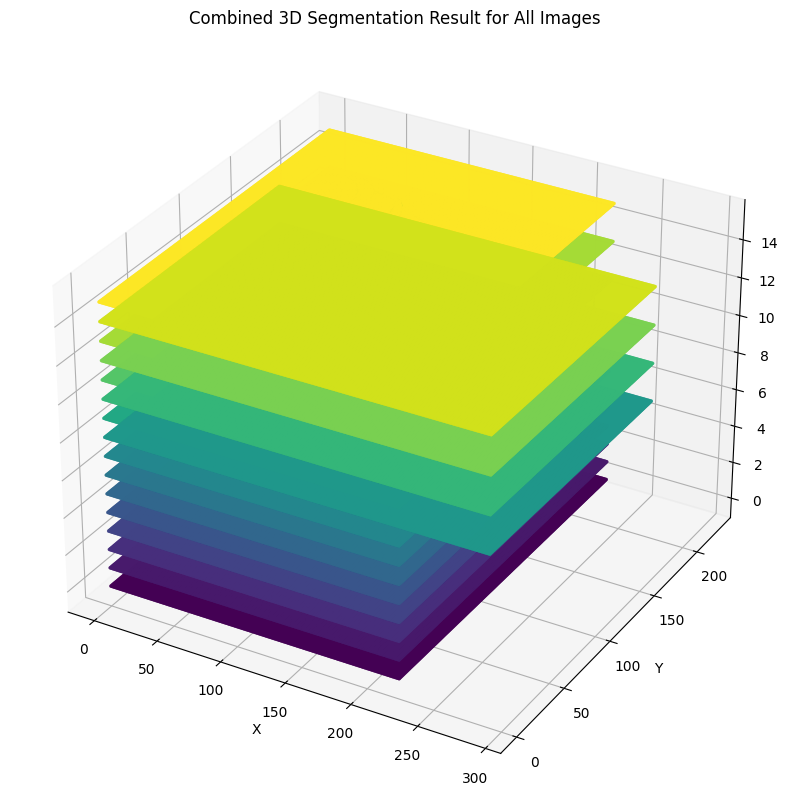

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio

labels_folder_path = "D:/GITHUB/PROJECTS/2D_TO_3D/pipeline_dataset"  # Adjust the path accordingly

label_images = []  # Initialize an empty list to store PyTorch tensors

# Iterate through each file in the labels folder
for file in sorted(os.listdir(labels_folder_path)):
    # Check if the file has one of the specified extensions
    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        # Read the image using imageio
        label_image = imageio.imread(os.path.join(labels_folder_path, file))
        # Convert the NumPy array to a PyTorch tensor and append to the list
        label_images.append(torch.from_numpy(label_image).float())

batch_size = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

colors = cm.viridis(torch.linspace(0, 1, len(label_images)))

for batch_start in range(0, len(label_images), batch_size):
    # Combine a batch of images into one 3D tensor
    predicted_labels_batch = torch.stack(label_images[batch_start:batch_start + batch_size], dim=0)

    # Iterate over each image's segmentation result in the batch
    for i in range(predicted_labels_batch.shape[0]):
        # Extract coordinates of non-zero values (assuming binary segmentation)
        non_zero_coords = predicted_labels_batch[i].nonzero()

        # Check if there are non-zero values before attempting to unpack
        if non_zero_coords.numel() > 0:
            if non_zero_coords.dim() == 2:
                x, y = non_zero_coords[:, 1], non_zero_coords[:, 0]
                z = torch.full_like(x, fill_value=i + batch_start)  # Use the image index as the z-coordinate
            elif non_zero_coords.dim() == 1:
                x, y = non_zero_coords[1], non_zero_coords[0]
                z = torch.full_like(x, fill_value=i + batch_start)  # Use the image index as the z-coordinate
            else:
                x, y, z = non_zero_coords.unbind(1)

            # Scatter plot with varying colors, marker size, and transparency
            ax.scatter(x, y, z, c=colors[i + batch_start], marker='o', s=2, alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Combined 3D Segmentation Result for All Images')

plt.show()


In [7]:
import open3d as op3
import numpy as np
from PIL import Image
import os

# Replace these paths with the actual paths to your image files
image_folder = "D:/GITHUB/PROJECTS/2D_TO_3D/pipeline_dataset"
depth_folder = '/path/to/your/depth/images'

# Load images
image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
depth_files = sorted([f for f in os.listdir(depth_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Assume images are of the same size
width, height = Image.open(os.path.join(image_folder, image_files[0])).size

# Create an empty point cloud
pcd = op3.geometry.PointCloud()

for image_file, depth_file in zip(image_files, depth_files):
    # Load RGB image
    rgb_image = np.asarray(Image.open(os.path.join(image_folder, image_file)))

    # Load depth image
    depth_image = np.asarray(Image.open(os.path.join(depth_folder, depth_file)))

    # Create point cloud from depth information
    points = []
    for v in range(height):
        for u in range(width):
            depth = depth_image[v, u]
            if depth > 0:
                point = [u, v, depth]
                color = rgb_image[v, u]
                # Convert color to a list before concatenating
                points.append(point + [color])

    points = np.array(points)
    pcd += op3.geometry.PointCloud()
    pcd.points = op3.utility.Vector3dVector(points[:, :3])
    pcd.colors = op3.utility.Vector3dVector(points[:, 3:] / 255.0)

# Downsample the point cloud
downpcd = pcd.voxel_down_sample(voxel_size=0.02)

# Estimate normals
downpcd.estimate_normals(search_param=op3.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Visualize the point cloud
op3.visualization.draw_geometries([downpcd])


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/path/to/your/depth/images'